In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Print out GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

# Virtual Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Tue Aug  2 10:40:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
| 27%   22C    P8     8W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   

In [ ]:
cd /content/drive/MyDrive/Thesis

In [ ]:
# !pip install tensorflow-addons
!pip install -U segmentation-models

In [2]:

# for data load
import datetime, os

# for reading and processing images
import imageio
from PIL import Image, ImageOps


from IPython.display import clear_output
# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.utils import get_source_inputs

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time

# SM_FRAMEWORK=K
SM_FRAMEWORK=tf.keras
import segmentation_models as sm

sm.set_framework('tf.keras')
K.backend.set_image_data_format('channels_last')
from segmentation_models import get_preprocessing
seed=25
tf.random.set_seed(seed)
np.random.seed(seed)
AUTOTUNE = tf.data.AUTOTUNE

Segmentation Models: using `keras` framework.


In [3]:
BACKBONE = 'efficientnetb3'
preprocess_input = get_preprocessing(BACKBONE)

In [4]:
model = sm.Unet(BACKBONE ,input_shape=(128, 128, 3),classes=10,activation='softmax', encoder_weights='imagenet')

2022-08-01 14:55:38.569503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 14:55:59.021866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-08-01 14:56:00.031946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9651 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-08-01 14:56:00.033312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/repli

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 40)   1080        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 40)   160         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 40)   0           ['stem_bn[0][0]']            

 block2a_activation (Activation  (None, 32, 32, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 144)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2a_se_reshape[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 32, 32, 32)   6144        ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 32, 32, 32)  128         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_d

 block3b_drop (FixedDropout)    (None, 16, 16, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 16, 16, 48)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, 16, 16, 288)  13824       ['block3b_add[0][0]']            
                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 16, 16, 288)  1152       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_e

 block4b_expand_activation (Act  (None, 8, 8, 576)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 8, 8, 576)   5184        ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 8, 8, 576)   0           ['block4b_bn[0][0]']             
 )        

                                                                                                  
 block4d_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 8, 8, 576)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 576)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 576)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 576)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 8, 8, 816)    0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 8, 8, 136)    110976      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5c_project_bn[0][0]']     
          

                                                                                                  
 block5e_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 8, 8, 136)    0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 8, 8, 816)    110976      ['block5e_add[0][0]']            
          

                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1392)  5568        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1392)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_b

 ivation)                                                                                         
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 4, 4, 1392)  0           ['block6e_bn[0][0]']             
 )                                                                                                
          

 block7a_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 4, 4, 1392)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1392)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block7a_se_squeeze[0][0]']     
          

                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, 8, 8, 256)    589824      ['decoder_stage0a_relu[0][0]']   
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 8, 8, 256)   1024        ['decoder_stage0b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0b_relu (Activati  (None, 8, 8, 256)   0           ['decoder_stage0b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, 16, 16, 256)  0          ['decoder_stage0b_relu[0][0]']   
 ampling2D

                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, 128, 128, 16  4608        ['decoder_stage4_upsampling[0][0]
                                )                                ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, 128, 128, 16  64         ['decoder_stage4a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage4a_relu (Activati  (None, 128, 128, 16  0          ['decoder_stage4a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_s

In [20]:
model.load_weights("../data/best_model_unet.h5")


In [4]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.
        For one Image path:
        .../dataset/images/image1.jpg
        Its corresponding annotation path is:
        .../dataset/masks/masks1.png

    Returns
    -------
    dict
        Dictionary mapping an image and its mask.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # Since 255 exist, changing it with 0
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an mask of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its masks.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    #added later, verify and check wheter to use normalize on masks
#     input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask
   

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its mask.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the mask also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its mask.

    Returns
    -------
    tuple
        A modified image and its mask.
    """
    print(datapoint['image'])
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    
    if tf.random.uniform(()) > 0.5:
          input_image = tf.image.flip_left_right(input_image)
          input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask   

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its mask.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the mask also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its mask.

    Returns
    -------
    tuple
        A modified image and its mask.
    """
#     print(datapoint['image'])
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask       

In [5]:

# dataset_path = '/content/drive/MyDrive/Thesis/drive/MyDrive/dataset/images/'
dataset_path = '../../dataset/images/'

all_dataset = tf.data.Dataset.list_files(dataset_path + "*.png", seed=seed)


2022-08-02 10:41:33.209918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 10:41:35.185397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-08-02 10:41:35.186201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9651 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-08-02 10:41:35.186813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/repli

In [6]:
test_dataset = all_dataset.take(288) 
train_dataset = all_dataset.skip(290)

TRAINSET_SIZE = len(train_dataset)
VALSET_SIZE= len(test_dataset)

print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(f"The Training Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1152 images.
The Training Dataset contains 288 images.


In [7]:
IMG_SIZE=128
BATCH_SIZE = 16 #32
BUFFER_SIZE = 500

train_dataset = train_dataset.map(parse_image)
test_dataset = test_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": test_dataset}

dataset['train'] = dataset['train'].map(load_image_train)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=seed)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)


dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

Tensor("datapoint:0", shape=(None, None, 3), dtype=uint8)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


2022-08-01 14:56:29.959581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 500
2022-08-01 14:56:35.577268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


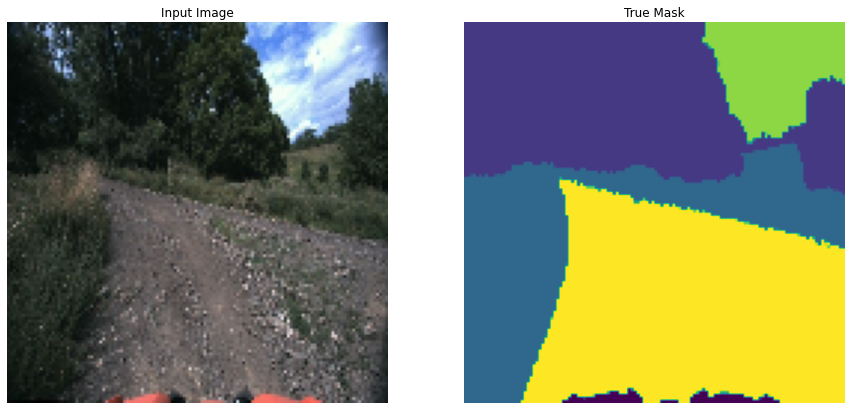

In [9]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

# print(sample_image)
display_sample([sample_image[0], sample_mask[0]])

In [11]:

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(
    K.optimizers.Adam(0.0001),
    loss=total_loss,
    metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()],
)

In [8]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [13]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    # DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
#     tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_efficientnetb3_unet.h5', verbose=1, save_best_only=True, save_weights_only=False)
]


In [14]:
# STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
# VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

results = model.fit(
   dataset['train'],
   epochs=100,
   steps_per_epoch = TRAINSET_SIZE // BATCH_SIZE,
   validation_steps= VALSET_SIZE // BATCH_SIZE,
   validation_data=dataset['val'],
   callbacks=callbacks
)

Epoch 1/100


2022-07-28 12:21:11.431868: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-28 12:21:19.548643: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 12:21:19.651846: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


72/72 [==============================] - ETA: 0s - loss: 2.2904 - iou_score: 0.1074 - f1-score: 0.1932

2022-07-28 12:21:42.418961: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 2.82398, saving model to best_efficientnetb3_unet.h5
72/72 [==============================] - 60s 293ms/step - loss: 2.2904 - iou_score: 0.1074 - f1-score: 0.1932 - val_loss: 2.8240 - val_iou_score: 0.1107 - val_f1-score: 0.1900
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 2.2245 - iou_score: 0.1072 - f1-score: 0.1935

2022-07-28 12:21:56.846577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 2: val_loss improved from 2.82398 to 2.19330, saving model to best_efficientnetb3_unet.h5
72/72 [==============================] - 14s 200ms/step - loss: 2.2245 - iou_score: 0.1072 - f1-score: 0.1935 - val_loss: 2.1933 - val_iou_score: 0.1071 - val_f1-score: 0.1934
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 2.2029 - iou_score: 0.1071 - f1-score: 0.1935

2022-07-28 12:22:11.886113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 3: val_loss did not improve from 2.19330
72/72 [==============================] - 12s 171ms/step - loss: 2.2029 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2289 - val_iou_score: 0.1072 - val_f1-score: 0.1936
Epoch 4/100
72/72 [==============================] - ETA: 0s - loss: 2.2141 - iou_score: 0.1071 - f1-score: 0.1935

2022-07-28 12:22:23.629195: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 4: val_loss did not improve from 2.19330
72/72 [==============================] - 12s 164ms/step - loss: 2.2141 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2434 - val_iou_score: 0.1072 - val_f1-score: 0.1937
Epoch 5/100
72/72 [==============================] - ETA: 0s - loss: 2.2101 - iou_score: 0.1071 - f1-score: 0.1935

2022-07-28 12:22:35.885132: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 5: val_loss improved from 2.19330 to 2.17874, saving model to best_efficientnetb3_unet.h5
72/72 [==============================] - 15s 210ms/step - loss: 2.2101 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.1787 - val_iou_score: 0.1070 - val_f1-score: 0.1934
Epoch 6/100
72/72 [==============================] - ETA: 0s - loss: 2.2071 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 6: val_loss did not improve from 2.17874
72/72 [==============================] - 12s 170ms/step - loss: 2.2071 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.1900 - val_iou_score: 0.1071 - val_f1-score: 0.1934
Epoch 7/100
72/72 [==============================] - ETA: 0s - loss: 2.2026 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 7: val_loss did not improve from 2.17874
72/72 [==============================] - 12s 163ms/step - loss: 2.2026 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2048 - val_iou_score: 0.1071 - val_f1-score: 0.1935
Epoch 8/100
72/72 [==============================] 

72/72 [==============================] - ETA: 0s - loss: 2.2239 - iou_score: 0.1072 - f1-score: 0.1936
Epoch 29: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 172ms/step - loss: 2.2239 - iou_score: 0.1072 - f1-score: 0.1936 - val_loss: 2.2124 - val_iou_score: 0.1071 - val_f1-score: 0.1935
Epoch 30/100
72/72 [==============================] - ETA: 0s - loss: 2.2118 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 30: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 164ms/step - loss: 2.2118 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.1868 - val_iou_score: 0.1071 - val_f1-score: 0.1934
Epoch 31/100
72/72 [==============================] - ETA: 0s - loss: 2.2094 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 31: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 171ms/step - loss: 2.2094 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2028 - val_iou_score: 0.1071 - val_f1-score: 

72/72 [==============================] - ETA: 0s - loss: 2.2075 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 77: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 173ms/step - loss: 2.2075 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2131 - val_iou_score: 0.1071 - val_f1-score: 0.1935
Epoch 78/100
72/72 [==============================] - ETA: 0s - loss: 2.2067 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 78: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 162ms/step - loss: 2.2067 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2279 - val_iou_score: 0.1072 - val_f1-score: 0.1936
Epoch 79/100
72/72 [==============================] - ETA: 0s - loss: 2.2089 - iou_score: 0.1071 - f1-score: 0.1935
Epoch 79: val_loss did not improve from 2.17011
72/72 [==============================] - 12s 163ms/step - loss: 2.2089 - iou_score: 0.1071 - f1-score: 0.1935 - val_loss: 2.2291 - val_iou_score: 0.1072 - val_f1-score: 

In [9]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(tf.reshape(Z, (Z.shape[0], -1)), axis=1)

# PGD L2 for Adversarial Examples #
"""PGD.

    Parameters
    ----------
    Model : [type], optional
        [Input dataset, by default None
    X,y : int, optional
        Number of sample to show, by default 1
    alpha : 
    epsilon:
    delta : 
    """
def single_pgd_step_adv(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta)

    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    z = delta + alpha * (grad / (normgrad + 1e-10))

    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_adv(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_adv)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

# Helper for pgd_linf
@tf.function
def onestep_pgd_linf(model, X, y, epsilon, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))

    delta = tf.clip_by_value(delta + alpha*tf.sign(tape.gradient(loss, delta)), X-epsilon, X+epsilon)
    
    return delta


def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = tf.zeros_like(X)
    for t in range(num_iter):
        delta = onestep_pgd_linf(model, X, y, epsilon, alpha, delta)
    return delta


@tf.function
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = tf.zeros_like(X)
    
    # use GradientTape to perform autodiff
    with tf.GradientTape() as tape:
        # specifically 'watch' delta
        # see here: https://www.tensorflow.org/guide/autodiff
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))
    delta = tf.sign(tape.gradient(loss, delta)) * epsilon
    return delta


In [10]:
def single_pgd_step_robust(model, X, y, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta)) # comparing to robust model representation layer
        
    grad = tape.gradient(loss, delta)
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    delta -= alpha*grad / (normgrad + 1e-10) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    return delta, loss

def pgd_l2_robust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    fn = tf.function(single_pgd_step_robust)
    for t in range(num_iter):
      delta, loss = fn(model, X, y, alpha, delta)
    # Prints out loss to evaluate if it's actually learning (currently broken)
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta


def single_pgd_step_nonrobust(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta) #tape.gradient(loss, delta)

    # equivalent to delta += alpha*grad / norm(grad), just for batching
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    # changed from plus to minus b/c trying to minimize with non-robust
    z = delta - alpha * (grad / (normgrad + 1e-10))
    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_nonrobust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_nonrobust)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta   

In [17]:

for image, mask in dataset['train']:
    print(image.shape)

(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 128, 3)
(16, 128, 

KeyboardInterrupt: 

In [18]:

one_img_batch = sample_image[0][tf.newaxis, ...]
X=one_img_batch
one_img_batch.shape

TensorShape([1, 128, 128, 3])

In [19]:
sample_mask[0].shape
one_mask_batch = sample_mask[0][tf.newaxis, ...]
one_mask_batch.shape

TensorShape([1, 128, 128, 1])

In [20]:
# Generate some adversarial examples
epsilon = 0.5
delta = pgd_l2_adv(model, one_img_batch, one_mask_batch, alpha=epsilon / 5, num_iter=7, epsilon=epsilon)
print(delta.shape)
Xd = one_img_batch + delta
delta_grad = delta

(1, 128, 128, 3)


NameError: name 'X_new' is not defined

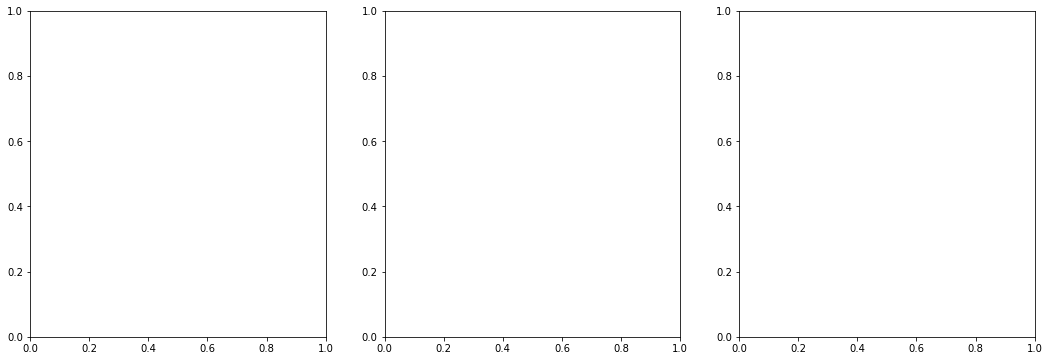

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs = axs.flatten()
axs[0].imshow(tf.squeeze(
    X_new, axis=0
).numpy())
axs[1].imshow(tf.squeeze(
    Xd, axis=0
).numpy())
axs[2].imshow(tf.squeeze(
    delta, axis=0
).numpy()+0.5)
plt.show()

In [11]:
def run_adversarial_attack(model, valid_dataset , attack, attack_params=None, **kwargs):
    """Runs only the adversarial attack on a trained model. 
    
    Differs from standard training by skipping the gradient updates which can be highly costly. Can be
    demonstrated from training model in standard way and then applying"""
    # Convert function to tf function
    attack_fn = tf.function(attack)

    t = time.time()
    test_losses = []
    test_accs = []
#     print(valid_dataset.length())
    for Xtest, ytest in valid_dataset:         
        # Run attack perturbation
        if attack_params is not None:
            delta = attack_fn(model, Xtest, ytest, **attack_params)
        else:
            delta = attack_fn(model, Xtest, ytest, **kwargs)
        
#         print(delta)
        Xdtest = Xtest + delta
        l, acc, *is_anything_else_being_returned = model.test_on_batch(Xdtest, ytest)
        print(l)
        clear_output(wait=True)
        test_losses.append(l)
        test_accs.append(acc)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
    print(f"Time: {(time.time()-t):0.2f} Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

In [24]:
count=0
for image, mask in dataset['val'].take(288):
    count+=1
    print(count)
    print(mask.shape)

1
(16, 128, 128, 1)
2
(16, 128, 128, 1)
3
(16, 128, 128, 1)
4
(16, 128, 128, 1)
5
(16, 128, 128, 1)
6
(16, 128, 128, 1)
7
(16, 128, 128, 1)
8
(16, 128, 128, 1)
9
(16, 128, 128, 1)
10
(16, 128, 128, 1)
11
(16, 128, 128, 1)
12
(16, 128, 128, 1)
13
(16, 128, 128, 1)
14
(16, 128, 128, 1)
15
(16, 128, 128, 1)
16
(16, 128, 128, 1)
17
(16, 128, 128, 1)
18
(16, 128, 128, 1)
19
(16, 128, 128, 1)
20
(16, 128, 128, 1)
21
(16, 128, 128, 1)
22
(16, 128, 128, 1)
23
(16, 128, 128, 1)
24
(16, 128, 128, 1)
25
(16, 128, 128, 1)
26
(16, 128, 128, 1)
27
(16, 128, 128, 1)
28
(16, 128, 128, 1)
29
(16, 128, 128, 1)
30
(16, 128, 128, 1)
31
(16, 128, 128, 1)
32
(16, 128, 128, 1)
33
(16, 128, 128, 1)
34
(16, 128, 128, 1)
35
(16, 128, 128, 1)
36
(16, 128, 128, 1)
37
(16, 128, 128, 1)
38
(16, 128, 128, 1)
39
(16, 128, 128, 1)
40
(16, 128, 128, 1)
41
(16, 128, 128, 1)
42
(16, 128, 128, 1)
43
(16, 128, 128, 1)
44
(16, 128, 128, 1)
45
(16, 128, 128, 1)
46
(16, 128, 128, 1)
47
(16, 128, 128, 1)
48
(16, 128, 128, 1)
4

In [36]:
dataset['val'].take(32).__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [23]:
for image, mask in dataset['val'].take(1):
    print(image.dtype)
    print(mask.dtype)

<dtype: 'float32'>
<dtype: 'float32'>


In [39]:
# PGD L2 attack
run_adversarial_attack(model, dataset['val'].take(32), attack=pgd_l2_adv, 
                       attack_params={'alpha':0.5/5, 'num_iter':7, 'epsilon':0.25 })

Time: 31.46 Test Loss: 2.22, Test Acc: 0.11


In [ ]:
model, X, y, alpha, num_iter, epsilon=0, example=False

In [40]:
# PGD L-infinity attack
run_adversarial_attack(model, dataset['val'].take(32), attack=pgd_linf, 
                       attack_params={'alpha':0.5/5, 'num_iter':7, 'epsilon':0.25 }) # {'epsilon':0.5, 'num_iter':7, 'alpha':0.5/5}

Time: 32.17 Test Loss: 2.21, Test Acc: 0.11


In [42]:
# FGSM attack
run_adversarial_attack(model, dataset['val'].take(32), attack=fgsm_attack, 
                       attack_params={'epsilon':0.25})

Time: 7.23 Test Loss: 2.25, Test Acc: 0.11


In [15]:
def adversarial_training(model, train_ds, test_ds, train_attack=pgd_l2_adv, test_attack=None, epochs=5, verbose=True, test_kwargs=None, **kwargs):
    """Runs the "adversarial" training loop described in Ilyas et al. (2019)
    
    Adversarial training allows for two separate attacks, one during training and a separate one during
    test. Note that if 'train_attack' is set to None, then this becomes standard training.
    
    Args:
        - model (TFModel): A compiled TF / Keras model
        - train_ds (TFData): a tensorflow data object for the training data
        - test_ds (TFData): a tensorflow data object for the test data 
        - attack (function): an attack function (i.e. PGD L2) to perturb
                test data if evaluating adversarial performance. Default : None
        - epochs (int): number of epochs to run training. Default: 5.
        - verbose (bool): Report results after each epoch. Otherwise
                will return the train / test accuracies at the end of training. 
                Default: True"""

    # Create train and test functions wrapped
    if train_attack is not None:
      train_attack_tf = tf.function(train_attack)
    if test_attack is not None:
      test_attack_tf = tf.function(test_attack)

    for n in range(epochs):
#         print(n)
        t = time.time()
        train_losses = []
        train_accs = []
        for b in train_ds:
            X, y = b
#             print("here")
            # Create adversarially perturbed training data
            if train_attack is not None:
                delta = train_attack_tf(model, X, y, **kwargs)
                Xd = X + delta
            else:
                Xd = X  
            # Train model on adversarially perturbed data
            l, l1, acc, other_returned_val = model.train_on_batch(Xd, y)
#             print(acc)
            train_losses.append(l)
            train_accs.append(acc)

        test_losses = []
        test_accs = []
        for vb in test_ds:
            Xtest, ytest = vb
            
            # When attack is specified (ie not None), apply
            # attack at test time; do not apply in training due to
            # 'standard_training' definition
            if test_attack is not None:
                if isinstance(test_kwargs, dict):
                    delta = test_attack_tf(model, Xtest, ytest, **test_kwargs)
                else:
                    delta = test_attack_tf(model, Xtest, ytest)
                Xdtest = Xtest + delta
            else:
                # when test_attack is not specified 
                Xdtest = Xtest
            
            l, l1, acc, other_returned_val = model.test_on_batch(Xdtest, ytest)
#             print({l}, {acc}, {other_returned_val})
            test_losses.append(l)
            test_accs.append(acc)
        
        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        
        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)
        
        if verbose:
            print(f"Epoch {n}/{epochs}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
                Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")
    
    # Return final train and test losses
    if verbose == False:
        return {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}

In [16]:
adv_train_model = sm.Unet(BACKBONE ,input_shape=(128, 128, 3),classes=10,
                activation='softmax', encoder_weights='imagenet')

In [17]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

adv_train_model.compile(
    K.optimizers.Adam(0.0001),
    loss=total_loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"],
)

In [18]:
adversarial_training(adv_train_model, dataset['train'].take(1152), dataset['val'].take(288), train_attack=pgd_l2_adv, 
                     epsilon=0.5, num_iter=7, alpha=0.5 / 5, epochs=25000 // 391)

2022-08-02 10:43:17.989648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-08-02 10:43:18.621468: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-02 10:43:18.655782: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 0/63, Time: 528.15 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 1/63, Time: 493.82 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.20, Test Acc: 0.00
Epoch 2/63, Time: 494.29 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 3/63, Time: 495.11 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 4/63, Time: 495.05 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 5/63, Time: 494.13 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 6/63, Time: 493.99 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 7/63, Time: 494.52 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.21, Test Acc: 0.00
Epoch 8/63, Time: 495.78 -- Train Loss: 2.21,                 Train Acc: 0.00, Test Loss: 2.20, Test Acc: 0.00
E

In [19]:
# Save the model
adv_train_model.save_weights('../data/adv_training_efficientnet.h5')


In [20]:
adv_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 40)   1080        ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 40)   160         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 40)   0           ['stem_bn[0][0]']          

 block2a_activation (Activation  (None, 32, 32, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 144)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2a_se_reshape[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 32, 32, 32)   6144        ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 32, 32, 32)  128         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_d

 block3b_drop (FixedDropout)    (None, 16, 16, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 16, 16, 48)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, 16, 16, 288)  13824       ['block3b_add[0][0]']            
                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 16, 16, 288)  1152       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_e

 block4b_expand_activation (Act  (None, 8, 8, 576)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 8, 8, 576)   5184        ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 8, 8, 576)   0           ['block4b_bn[0][0]']             
 )        

                                                                                                  
 block4d_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 8, 8, 576)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 576)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 576)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 576)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 8, 8, 816)    0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 8, 8, 136)    110976      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5c_project_bn[0][0]']     
          

                                                                                                  
 block5e_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 8, 8, 136)    0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 8, 8, 816)    110976      ['block5e_add[0][0]']            
          

                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1392)  5568        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1392)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_b

 ivation)                                                                                         
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 4, 4, 1392)  0           ['block6e_bn[0][0]']             
 )                                                                                                
          

 block7a_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 4, 4, 1392)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1392)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block7a_se_squeeze[0][0]']     
          

                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, 8, 8, 256)    589824      ['decoder_stage0a_relu[0][0]']   
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 8, 8, 256)   1024        ['decoder_stage0b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0b_relu (Activati  (None, 8, 8, 256)   0           ['decoder_stage0b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, 16, 16, 256)  0          ['decoder_stage0b_relu[0][0]']   
 ampling2D

                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, 128, 128, 16  4608        ['decoder_stage4_upsampling[0][0]
                                )                                ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, 128, 128, 16  64         ['decoder_stage4a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage4a_relu (Activati  (None, 128, 128, 16  0          ['decoder_stage4a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_s

## Robustifier

In [21]:
# Create the robustifier model 
# (which is the adversarially trained model without the last layer)
# adv_training.summary()
representation = adv_train_model.layers[-2]
robustifier = tf.keras.Model(inputs = adv_train_model.layers[0].input, 
                             outputs = representation.output)
robustifier.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 40)   1080        ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 40)   160         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 40)   0           ['stem_bn[0][0]']          

 block2a_activation (Activation  (None, 32, 32, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 144)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2a_se_reshape[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 32, 32, 32)   6144        ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 32, 32, 32)  128         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_d

 block3b_drop (FixedDropout)    (None, 16, 16, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 16, 16, 48)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, 16, 16, 288)  13824       ['block3b_add[0][0]']            
                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 16, 16, 288)  1152       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_e

 block4b_expand_activation (Act  (None, 8, 8, 576)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 8, 8, 576)   5184        ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 8, 8, 576)   0           ['block4b_bn[0][0]']             
 )        

                                                                                                  
 block4d_bn (BatchNormalization  (None, 8, 8, 576)   2304        ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 8, 8, 576)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 576)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 576)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 576)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 8, 8, 816)    0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 8, 8, 136)    110976      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5c_project_bn[0][0]']     
          

                                                                                                  
 block5e_project_bn (BatchNorma  (None, 8, 8, 136)   544         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (FixedDropout)    (None, 8, 8, 136)    0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 8, 8, 136)    0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 8, 8, 816)    110976      ['block5e_add[0][0]']            
          

                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1392)  5568        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1392)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_b

 ivation)                                                                                         
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 4, 4, 1392)  34800       ['block6e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 4, 4, 1392)  0           ['block6e_bn[0][0]']             
 )                                                                                                
          

 block7a_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 4, 4, 1392)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1392)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block7a_se_squeeze[0][0]']     
          

                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, 8, 8, 256)    589824      ['decoder_stage0a_relu[0][0]']   
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 8, 8, 256)   1024        ['decoder_stage0b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0b_relu (Activati  (None, 8, 8, 256)   0           ['decoder_stage0b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, 16, 16, 256)  0          ['decoder_stage0b_relu[0][0]']   
 ampling2D

                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, 128, 128, 16  4608        ['decoder_stage4_upsampling[0][0]
                                )                                ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, 128, 128, 16  64         ['decoder_stage4a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage4a_relu (Activati  (None, 128, 128, 16  0          ['decoder_stage4a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_s

## Create Robust Dataset

In [ ]:
%%time
def robustify(robust_mod, train_ds, iters=1000, alpha=0.1, batch_size=BATCH_SIZE):
    robust_train = []
    orig_labels = []
    example = False

    train_to_pull = list(iter(train_ds))
    start_rn = np.random.randint(0, len(train_ds))
    rand_batch = train_to_pull[start_rn][0]

    start_time = time.time()
    for i, (img_batch, label_batch) in enumerate(train_ds):
        inter_time = time.time()  

        # For the last batch, it is smaller than batch_size and thus we match the size for the batch of initial images
        if img_batch.shape[0] < batch_size:
            rand_batch = rand_batch[:img_batch.shape[0]]

        # Get the goal representation
        goal_representation = robust_mod(img_batch)
      
        # Upate the batch of images
        learned_delta = pgd_l2_robust(robust_mod, rand_batch, goal_representation, alpha=alpha, num_iter=iters)
        robust_update = (rand_batch + learned_delta)

        # Add the updated images and labels to their respective lists
        robust_train.append(robust_update)
        orig_labels.append(label_batch)
      
        # Measure the time
        if (i+1) % 10 == 0:
            elapsed = time.time() - start_time
            elapsed_tracking = time.time() - inter_time
            print(f'Robustified {(i+1)*batch_size} images in {elapsed:0.3f} seconds; Took {elapsed_tracking:0.3f} seconds for this particular iteration')    
      
      # Reset random image batch
        rn = np.random.randint(0, len(train_ds)-1) # -1 because last batch might be smaller
        rand_batch = train_to_pull[rn][0]

    return robust_train, orig_labels

robust_train, orig_labels = robustify(robustifier, dataset['train'].take(1152), iters=1000, alpha=0.1)

# Print out the shapes
print(tf.concat(robust_train, axis=0).shape)
print(tf.concat(orig_labels, axis=0).shape)

Robustified 160 images in 516.179 seconds; Took 51.924 seconds for this particular iteration
Robustified 320 images in 1034.541 seconds; Took 51.800 seconds for this particular iteration
Robustified 480 images in 1558.173 seconds; Took 52.523 seconds for this particular iteration
Robustified 640 images in 2078.632 seconds; Took 51.664 seconds for this particular iteration
Robustified 800 images in 2600.944 seconds; Took 52.901 seconds for this particular iteration
Robustified 960 images in 3119.208 seconds; Took 52.619 seconds for this particular iteration
Robustified 1120 images in 3633.242 seconds; Took 51.231 seconds for this particular iteration
Robustified 1280 images in 4154.501 seconds; Took 51.617 seconds for this particular iteration
Robustified 1440 images in 4676.030 seconds; Took 51.985 seconds for this particular iteration
Robustified 1600 images in 5198.207 seconds; Took 52.125 seconds for this particular iteration
Robustified 1760 images in 5719.782 seconds; Took 53.220 

In [ ]:
def robust_preprocess(img, label):
    """Defines preprocessing / data augmentation for robust & nonrobust features"""
    img = tf.image.resize_with_pad(img, 32+4, 32+4)
    img = tf.image.random_crop(img, size=[32, 32, 3])
    img = tf.image.stateless_random_flip_left_right(img, (15, 13))
    return img, label

In [ ]:
# Convert to TensorFlow Dataset
robust_ds = tf.data.Dataset.from_tensor_slices((tf.concat(robust_train, axis=0), tf.concat(orig_labels, axis=0))).prefetch(AUTOTUNE).map(robust_preprocess, 
                                                                                                                                         num_parallel_calls=AUTOTUNE).shuffle(                                                                                                                                       len(robust_train)).batch(BATCH_SIZE)

In [ ]:
# Save the tensorflow datasets
tf.data.experimental.save(robust_ds, 'drive/MyDrive/AM207_Final_Project/resnet9_robust_ds')

# Load the tensorflow datasets
robust_ds = tf.data.experimental.load('drive/MyDrive/AM207_Final_Project/resnet9_robust_ds')

